<a href="https://colab.research.google.com/github/ranadeepbhuyan/cancer-mri-analysis/blob/main/vopo/PKG_UPENN_GBM_NIfTI_files_image_sliced_detection_along_x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
based_path = r"/content/drive/MyDrive/PKG - UPENN-GBM NIFTI 3d to 2d exp 2/along x/patients data into 64 parts"

In [ ]:
#fatching ids form data path
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x


train_data_ids = [f.path for f in os.scandir(based_path)]

training_data_ids = pathListIntoIds(train_data_ids);

In [ ]:
len(training_data_ids)

63453

In [ ]:
def fetch_blocks(block_no, ids):
  block = []
  for i in range(len(ids)):
    test0 = ids[i]
    test = test0.split('-')[5]
    test1 = test.split('_')[0]
    if test1 == str(block_no):
      block.append(test0)
  return block

In [ ]:
block = fetch_blocks(block_no=10, ids = training_data_ids)

In [ ]:
len(block)

0

In [ ]:
for i in range(len(block)):
  test3 = block[i].split('_')[2]
  test2 = test3.split('.')[0]
  if test2.isdigit() == False:
    block.remove(block[i])


In [ ]:
len(block)

0

In [ ]:
listno = []
for i in range(0,20):
  listno.append(f'{i}')

In [ ]:
patients_data = []
for i in range(len(training_data_ids)):
  test = training_data_ids[i].split('-')[3]
  for F in range(0,20):
    if test == listno[F]:
      patients_data.append(training_data_ids[i])


In [ ]:
len(patients_data)

13799

In [ ]:
def data_prepare(ids):
  data_path = []
  data_ids = []
  desired_width = 30
  desired_height = 30
  for i in range(len(ids)):
    path = os.path.join(based_path, ids[i])
    img_data = cv2.imread(path)
    gray_image = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray_image, (desired_width, desired_height), interpolation=cv2.INTER_LINEAR)
    test1 = ids[i].split('_')[2]
    test = test1.split('.png')[0]
    data_path.append(resized_image)
    data_ids.append(int(test))
  return data_path, data_ids


data_path, data_ids = data_prepare(block)

data_column = {'image_data': data_path,
        'class': data_ids}
data_set = pd.DataFrame(data_column)

In [ ]:
data_list = data_set['image_data'].tolist()
classes = data_set['class'].tolist()

In [ ]:
my_array = np.array(data_list)
y_data = np.array(classes)

In [ ]:
my_array.shape

(4239, 30, 30)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(my_array,y_data, test_size=0.10)

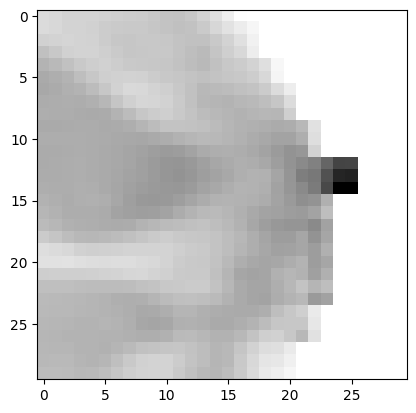

In [ ]:
from tensorflow.keras.utils import normalize

x_train = normalize(x_train, axis=1)
x_test = normalize(x_test, axis=1)
plt.imshow(x_train[1], cmap =plt.cm.binary)

In [ ]:
x_train = np.array(x_train).reshape(-1,30,30,1)
x_test = np.array(x_test).reshape(-1,30,30,1)
print(x_train.shape,x_test.shape)

(3815, 30, 30, 1) (424, 30, 30, 1)


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation,Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import HeNormal

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(64))
model.add(Activation('softmax'))


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 activation_20 (Activation)  (None, 30, 30, 32)        0         
                                                                 
 dropout_16 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 activation_21 (Activation)  (None, 15, 15, 64)        0         
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=5,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [ ]:
h = model.fit(x_train, y_train, batch_size = 32, validation_split= 0.1, epochs=200, callbacks=[checkpointer, earlystopping, reduce_lr])

Epoch 1/200
106/108 [============================>.] - ETA: 0s - loss: 2.3004 - accuracy: 0.2671
Epoch 1: val_loss improved from inf to 1.90305, saving model to clf-resnet-weights.hdf5
108/108 [==============================] - 4s 21ms/step - loss: 2.2929 - accuracy: 0.2697 - val_loss: 1.9030 - val_accuracy: 0.3743 - lr: 0.0010
Epoch 2/200
107/108 [============================>.] - ETA: 0s - loss: 1.5286 - accuracy: 0.4492
Epoch 2: val_loss improved from 1.90305 to 1.59754, saving model to clf-resnet-weights.hdf5
108/108 [==============================] - 2s 19ms/step - loss: 1.5274 - accuracy: 0.4498 - val_loss: 1.5975 - val_accuracy: 0.4948 - lr: 0.0010
Epoch 3/200
107/108 [============================>.] - ETA: 0s - loss: 1.3375 - accuracy: 0.5210
Epoch 3: val_loss improved from 1.59754 to 1.47632, saving model to clf-resnet-weights.hdf5
108/108 [==============================] - 2s 18ms/step - loss: 1.3366 - accuracy: 0.5217 - val_loss: 1.4763 - val_accuracy: 0.5681 - lr: 0.0010
Ep

In [ ]:
test_loss, test_acc = model.evaluate(x_test,y_test)

14/14 [==============================] - 0s 4ms/step - loss: 0.6625 - accuracy: 0.8113


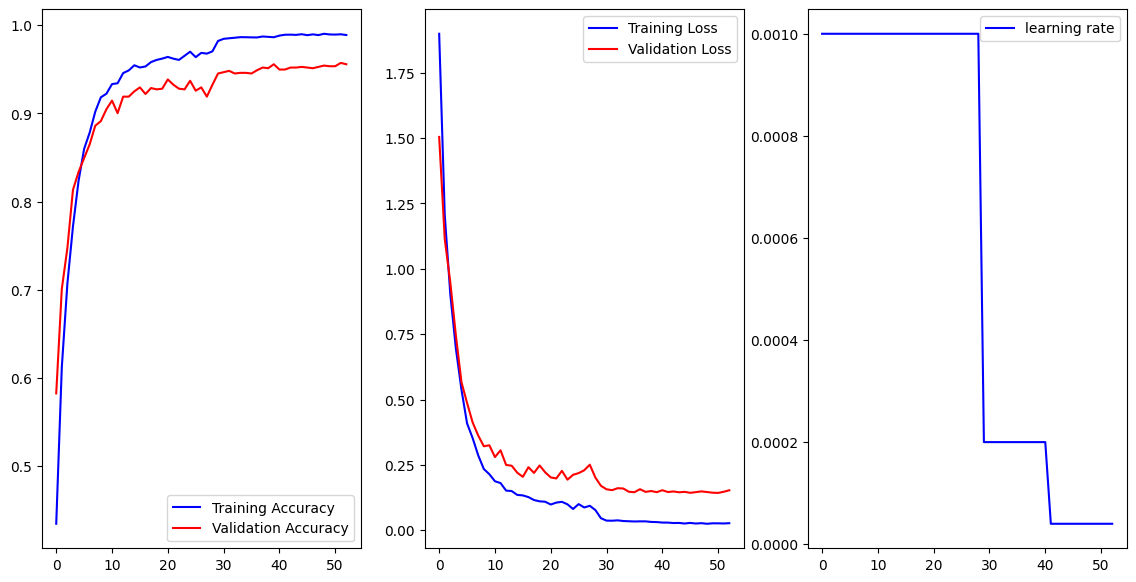

In [ ]:
acc=h.history['accuracy']
val_acc=h.history['val_accuracy']

epoch=range(len(acc)-13)

loss=h.history['loss']
val_loss=h.history['val_loss']

learning_rate = h.history['lr']

acc_till_val_loss_improve = []
val_acc_till_val_loss_improve = []
val_loss_till_val_loss_improve = []
loss_till_val_loss_improve = []
learning_rate_till_val_loss_improve = []

for i in range(len(acc)-13):
  acc_till_val_loss_improve.append(acc[i])
  val_acc_till_val_loss_improve.append(val_acc[i])
  val_loss_till_val_loss_improve.append(val_loss[i])
  loss_till_val_loss_improve.append(loss[i])
  learning_rate_till_val_loss_improve.append(learning_rate[i])

f,ax=plt.subplots(1,3,figsize=(14,7))

ax[0].plot(epoch,acc_till_val_loss_improve,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc_till_val_loss_improve,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss_till_val_loss_improve,'b',label='Training Loss')
ax[1].plot(epoch,val_loss_till_val_loss_improve,'r',label='Validation Loss')
ax[1].legend()


ax[2].plot(epoch,learning_rate_till_val_loss_improve,'b',label='learning rate')
ax[2].legend()



plt.show()

In [ ]:
prediction = model.predict(x_test)

In [ ]:
len(prediction)

In [ ]:
not_match = []
not_match_ids = []
for i in range(len(prediction)):
  x = np.argmax(prediction[i])
  if x != y_test[i]:
    not_match.append(prediction[i])
    not_match_ids.append(i)

In [ ]:
for i in not_match_ids:
  print("Ids : ",i, "pred :",np.argmax(prediction[i]), "actual :", y_test[i])

In [ ]:
len(not_match)